In [3]:
%cd /content/drive/MyDrive/Pneumonia_Detection/chest_xray

/content/drive/MyDrive/Pneumonia_Detection/chest_xray


images-size: torch.Size([32, 3, 256, 256])
out-size: torch.Size([3, 1034, 2066])


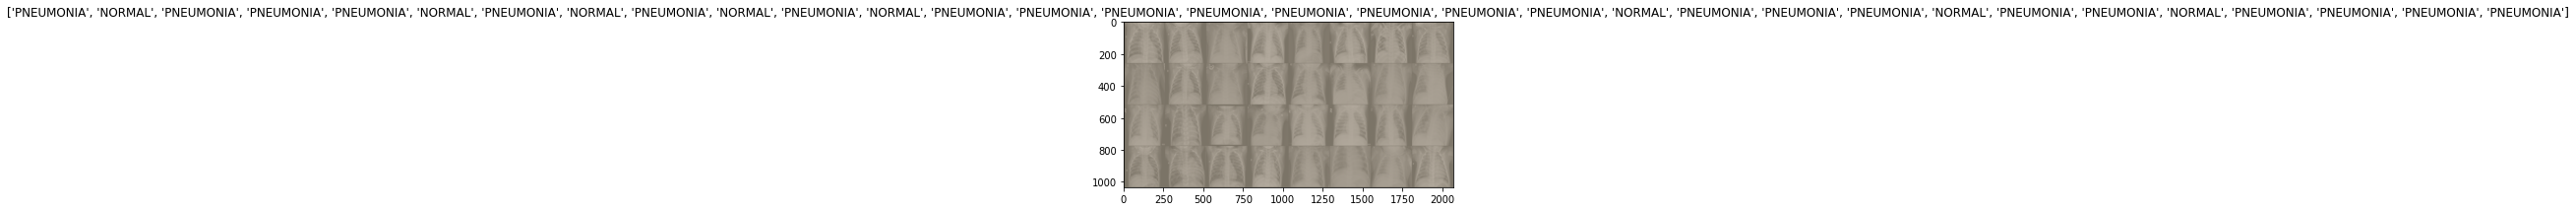

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import copy
import os
batch_size = 32
learning_rate = 1e-3
transforms = transforms.Compose(
[
    transforms.Resize((256,256)),
    transforms.ToTensor()

])
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Pneumonia_Detection/chest_xray/train', transform=transforms)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Pneumonia_Detection/chest_xray/test', transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def imshow(inp, title=None):
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
      plt.title(title)
    plt.pause(0.001)

images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)
out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)


imshow(out, title=[train_dataset.classes[x] for x in labels])

In [ ]:
resnet = models.resnet18(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.0001, momentum=0.9)
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 128)
resnet.fc = resnet.fc.to(device)

In [7]:
n_epochs = 10
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        outputs = resnet(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))

    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        resnet.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = resnet(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)

        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        if network_learned:
            valid_loss_min = batch_loss
            torch.save(resnet.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    resnet.train()

Epoch 1

Epoch [1/10], Step [0/163], Loss: 5.0331
Epoch [1/10], Step [20/163], Loss: 5.0360
Epoch [1/10], Step [40/163], Loss: 4.8241
Epoch [1/10], Step [60/163], Loss: 4.7776
Epoch [1/10], Step [80/163], Loss: 4.7164
Epoch [1/10], Step [100/163], Loss: 4.5768
Epoch [1/10], Step [120/163], Loss: 4.3574
Epoch [1/10], Step [140/163], Loss: 4.1150
Epoch [1/10], Step [160/163], Loss: 3.7901

train-loss: 4.5418, train-acc: 11.8098
validation loss: 4.0263, validation acc: 33.1731

Improvement-Detected, save-model
Epoch 2

Epoch [2/10], Step [0/163], Loss: 4.0558
Epoch [2/10], Step [20/163], Loss: 3.8991
Epoch [2/10], Step [40/163], Loss: 3.2975
Epoch [2/10], Step [60/163], Loss: 3.4162
Epoch [2/10], Step [80/163], Loss: 2.9820
Epoch [2/10], Step [100/163], Loss: 2.6961
Epoch [2/10], Step [120/163], Loss: 2.7222
Epoch [2/10], Step [140/163], Loss: 2.3342
Epoch [2/10], Step [160/163], Loss: 3.0061

train-loss: 3.7893, train-acc: 74.1948
validation loss: 3.4515, validation acc: 75.9615

Improve

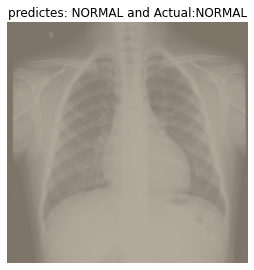

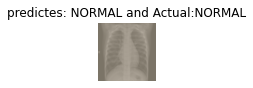

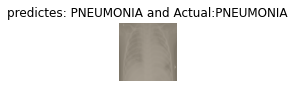

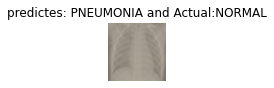

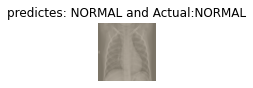

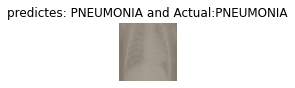

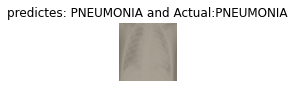

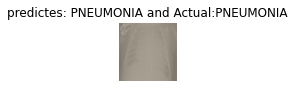

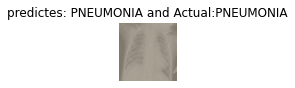

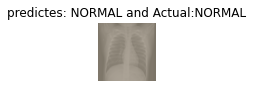

In [27]:
def visualize_model(resnet, num_images=10):
    images_so_far = 0
    fig = plt.figure(figsize=(25, 25))
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if str(device) in ['cuda']:
            inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.to('cpu').numpy() if str(device) in ['cuda'] else preds.to('cpu').numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: '+str(test_dataset.classes[preds[j]])+' and Actual:'+str(test_dataset.classes[labels[j]]))
            imshow(inputs[j])
            if images_so_far == num_images:
                return 
plt.ion()
visualize_model(resnet)
plt.ioff()